## Test model

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# keras imports
import keras
from create_model import create_VGG
from data_utils import load_ava, clean_data

# allow memmory dynamic memmory allocation
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [2]:
#model_name = 'best_model.h5'
model_name = 'best_model_0.09.h5'
result_dir = './results'

vgg_16 = create_VGG()
vgg_16.load_weights(os.path.join(result_dir, model_name))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
# directory where we are going to work on
#workdir = './data'
workdir = '/home/frubio/AVA/'

In [4]:
# load and clean the dataset
x_train, y_train = load_ava(workdir)
x_train, y_train = clean_data(workdir, x_train, y_train)

Total images lost:  178
Original dataset shape:  (255530,)
Resulting dataset shape:  (255352,)


Filename:  95020.jpg


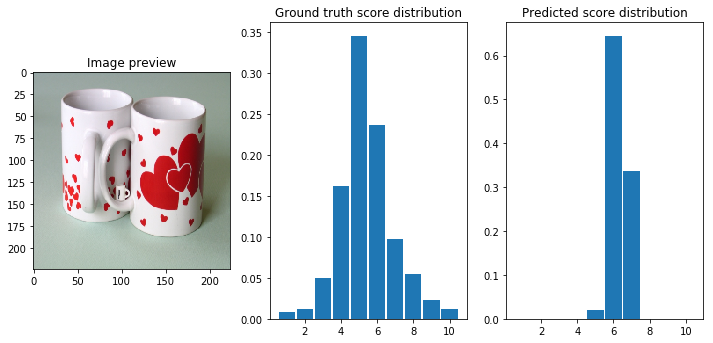

Filename:  496635.jpg


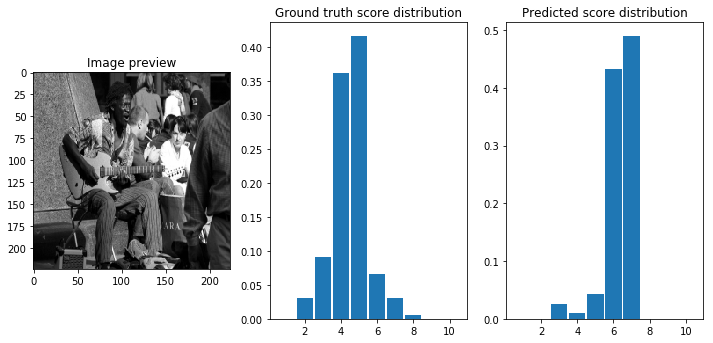

Filename:  854144.jpg


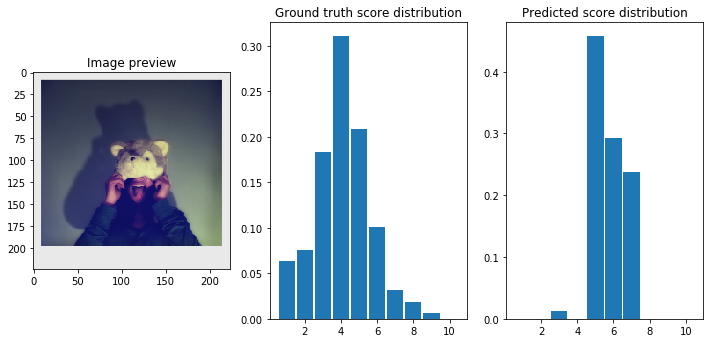

In [6]:
train_dir_images = os.path.join(workdir, 'AVA_images')

# number of random samples to be plotted
n_rand_samples = 3

# obtain n_rand_samples from the validation subset
val_indxs = np.random.randint(0, len(x_train), n_rand_samples)
val_images_name = x_train[val_indxs] 
val_labels_true = y_train[val_indxs]

val_images = []

# load the images into memmory
for image in val_images_name:
    case_filename = str(image) + '.jpg'
    case = os.path.join(train_dir_images, case_filename)
    val_images.append(cv2.resize(cv2.cvtColor(cv2.imread(case, 1), cv2.COLOR_BGR2RGB), (224, 224)))

val_images = np.array(val_images)
val_labels_pred = vgg_16.predict(val_images)

# plot n_rand_samples
for i in range(n_rand_samples):

    case_filename = str(val_images_name[i]) + '.jpg'
    case = os.path.join(train_dir_images, case_filename)
    print("Filename: ", case_filename)
    
    plt.figure(figsize=(12, 12))

    # open image with opencv and visualize it
    plt.subplot(2, 3, 1)
    image = cv2.resize(cv2.cvtColor(cv2.imread(case, 1), cv2.COLOR_BGR2RGB), (224, 224)) # cv2 loads an image BGR rather than RGB
    plt.title('Image preview')
    plt.imshow(image)
    
    # plot the ground truth score distribution of the image
    plt.subplot(2, 3, 2)
    punt_true = val_labels_true[i]
    punt_true = punt_true / np.sum(punt_true)
    plt.title('Ground truth score distribution')
    plt.bar(np.arange(1,11), height = punt_true, width = 0.9)
    
    # plot the predicted score distribution of the image
    plt.subplot(2, 3, 3)
    punt_pred = val_labels_pred[i]
    plt.title('Predicted score distribution')
    plt.bar(np.arange(1,11), height = punt_pred, width = 0.9)
    
    plt.show()